<a href="https://colab.research.google.com/github/ivganev/imdb-movie-reviews/blob/main/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# IMDB Dataset of 50K Movie Reviews




In this notebook, we perform a sentiment analysis on a Kaggle dataset of movie reviews. Here is the description from Kaggle:

"IMDB dataset having 50K movie reviews for natural language processing or Text analytics. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So, predict the number of positive and negative reviews using either classification or deep learning algorithms."

The approach we take in this notebook is to use a recurrent neural network with a long short-term memory (LSTM) cell. Step-by-step:

* Obtain the data from Kaggle.

* Preprocess the data by tokenizing words and forming a vocabulary.

* Form the LSTM neural network model.  

* Split the data into train and test set as indicated (25K each).

* Train the model using stochastic gradient descent. Due to GPU constraints, I was not able to train on the entire data set.

* Evaluate the model on the test set.

We begin with standard imports:

In [1]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
from matplotlib import pyplot as plt
import csv

## 1. Obtaining and preprocessing the data

### Obtain the data from Kaggle

The first step is to obtain the data from Kaggle. We follow the instructions on this [page](https://towardsdatascience.com/downloading-kaggle-datasets-directly-into-google-colab-c8f0f407d73a). The first step is to mount google drive:

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive



We set the Kaggle configuration directory to be where the kaggle.json token is located.

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/gdrive/MyDrive/kaggle'

Download the movie reviews data (this requires installation of the kaggle package via `pip install kaggle`, if necessary).


In [4]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 86% 22.0M/25.7M [00:00<00:00, 116MB/s] 
100% 25.7M/25.7M [00:00<00:00, 123MB/s]


Finally, copy the zip to the virtual machine and unzip it there.


In [5]:
zip_path = '/gdrive/MyDrive/kaggle/imdb-dataset-of-50k-movie-reviews.zip'
!cp '{zip_path}' .
!unzip -q 'imdb-dataset-of-50k-movie-reviews.zip'
os.listdir()

['.config',
 'IMDB Dataset.csv',
 'imdb-dataset-of-50k-movie-reviews.zip',
 'sample_data']

Check the working directory to see that the necessary files are there.


In [6]:
os.listdir()

['.config',
 'IMDB Dataset.csv',
 'imdb-dataset-of-50k-movie-reviews.zip',
 'sample_data']

### Read the data

The next step is to read the data into a pandas dataframe.

In [7]:
# Read the data into a pandas dataframe
data = pd.read_csv("IMDB Dataset.csv", lineterminator='\n', converters={"review": str(), "sentiment": str()})
num_samples = len(data)
data.head(), data.tail()

(                                              review sentiment
 0  One of the other reviewers has mentioned that ...  positive
 1  A wonderful little production. <br /><br />The...  positive
 2  I thought this was a wonderful way to spend ti...  positive
 3  Basically there's a family where a little boy ...  negative
 4  Petter Mattei's "Love in the Time of Money" is...  positive,
                                                   review sentiment
 49995  I thought this movie did a down right good job...  positive
 49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
 49997  I am a Catholic taught in parochial elementary...  negative
 49998  I'm going to have to disagree with the previou...  negative
 49999  No one expects the Star Trek movies to be high...  negative)

### Tokenize

The next few steps involve producing the vocabulary. First, we define a function to remove punctuation and numbers. Unit tests can be run, if desired.



In [8]:
import re

def preprocess_string(s):
    """ Keep only words, and make them lower case. Remove breaks."""
    s = re.sub(r"[^\w\s]", '', s).lower()
    s = re.sub(r"\s+", '', s)
    s = re.sub(r"\d", '', s)
    if s == "br": return ""
    return s

test = False
if test:
  assert preprocess_string("\"A") == "a"
  assert preprocess_string("&") == ""
  assert preprocess_string("(I") == "i"
  assert preprocess_string("/><br") == ""
  assert preprocess_string("don't") == "dont"
  assert preprocess_string("!!!") == ""
  assert preprocess_string("America\'s") == "americas"
  assert preprocess_string("5") == ""

Next, we tokenize the reviews by splitting them into words, and applying preprocessing to each word.

In [9]:
data["review_tokenized"] = data["review"].apply(
    lambda review_text : [preprocess_string(word) for word in review_text.split()]
)
data.head()

,review,sentiment,review_tokenized
0,One of the other reviewers has mentioned that ...,positive,"[one, of, the, other, reviewers, has, mentione..."
1,A wonderful little production. <br /><br />The...,positive,"[a, wonderful, little, production, , , the, fi..."
2,I thought this was a wonderful way to spend ti...,positive,"[i, thought, this, was, a, wonderful, way, to,..."
3,Basically there's a family where a little boy ...,negative,"[basically, theres, a, family, where, a, littl..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[petter, matteis, love, in, the, time, of, mon..."


### The vocabulary

The vocabulary encapuslates the frequencies of the tokens, and lets us move between tokens and indices.

In [10]:
from collections import Counter
import itertools

class Vocab:
    """
    The Vocab sorts the tokens by descending frequency, and creates dictionaries to move between tokens and indices
    """
    def __init__(self, tokenized_list : list, min_freq: int = 0):
        tokens = list(itertools.chain.from_iterable(tokenized_list))
        counts = Counter(tokens)
        self.token_freqs = sorted(counts.items(), key=lambda x: x[1], reverse=True)
        self.idx_to_token = list(sorted(set(
            ['<unk>'] + [token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}


    def __len__(self):
        return len(self.idx_to_token)

We can now create the vocab for our tokenized reviews.

In [ ]:
vocab = Vocab(data["review_tokenized"].to_list(), min_freq=5)

vocab_verbose =False
if vocab_verbose:
  print(len(vocab))
  print(vocab.idx_to_token[:10])
  print(vocab.idx_to_token[200:210])
  print(vocab.idx_to_token[-10:])

In [ ]:
def convert_tokenized_review_to_indices(tokenized_review):
    indices = []
    for token in tokenized_review:
        if token in vocab.token_to_idx and token:
            indices.append(vocab.token_to_idx[token])
    return indices


In [ ]:
# Convert the tokenized reviews to indices
data["review_token_indexed"] = data["review_tokenized"].apply(
    lambda review_tokens : convert_tokenized_review_to_indices(review_tokens)
)

# Find the maximum length so that we know how much to pad
max_length = data["review_token_indexed"].apply(lambda l : len(l)).max()
print(f"max length of tokenized processed review = {max_length}")

# Pad the tokenized, indexed reviews
features = torch.tensor(data["review_token_indexed"].apply(
    lambda review_tokens : [0]*(max_length- len(review_tokens)) + review_tokens
))
print(f"size of features = {features.size()}")

# For the labels, encode positive as 1 and negative as 0
labels = torch.tensor(data["sentiment"].apply(lambda s: int(s == "positive"))).unsqueeze(1).float()
print(f"size of labels = {labels.size()}")


max length of tokenized processed review = 2383
size of features = torch.Size([50000, 2383])
size of labels = torch.Size([50000, 1])



## 2. Model and training

### Hidden state recurrent NN

Now I define the recurrent neural network model. The model is many-to-one since we input a tokenized string but output only a single value (positive/negative). Hence, I have a hidden recurrent neural network that outputs a single value at the end, and this value is plugged into a fully connected neural network.

In [ ]:
class RNNHidden(nn.Module):
    def __init__(self, num_layers, input_dim, embedding_dim, hidden_dim):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first = True)

    def forward(self, text):

        #text.size() = (batch size, length of sequence)
        embedded = self.embedding(text)

        #embedded.size() = (batch_size, length of sequence)
        _, hidden = self.lstm(embedded)

        # Since this is a Many-to-One model, return only the last output
        return hidden[-1][0]

### Split into train and test

In [ ]:
# As indicated in the data description, use a 50/50 percent split into train and test sets
train_size = 0.5
test_size = 0.5

In [ ]:
split_id = int(len(features) * train_size)
x_train, x_test = features[:split_id], features[split_id:]
y_train, y_test = labels[:split_id], labels[split_id:]

# print out the shape
print('Feature Shapes:')
print('-------------')
print('Training:\t {}'.format(list(x_train.shape)))
print('Testing:\t {}'.format(list(x_test.shape)))
print()
print('Label Shapes:')
print('-------------')
print('Training:\t {}'.format(list(y_train.shape)))
print('Testing:\t {}'.format(list(y_test.shape)))

Feature Shapes:
-------------
Training:	 [25000, 2383]
Testing:	 [25000, 2383]

Label Shapes:
-------------
Training:	 [25000, 1]
Testing:	 [25000, 1]


### Training set-up

The next few cells set up the training of our model by checking if there is a GPU, defining the accuracy function, and definig the training loop.

In [ ]:
is_cuda = torch.cuda.is_available()

# If there is a GPU available, the device will be the GPU.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
# Binary accuracy function for evaluation
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

We arrive at the training loop for the network.

In [ ]:
import tqdm

def train(model, features, labels, optimizer, criterion, num_epochs):

    losses = []
    accs = []

    model.train()

    for i in tqdm.tqdm(range(num_epochs)):
      if (i+1) % 100 == 0:
        print(f"Epoch {i+1}: loss = {round(losses[-1],4)}, accuracy = {round(accs[-1],4)}")

      optimizer.zero_grad()
      predictions = model(features)
      loss = criterion(predictions, labels)
      acc = binary_accuracy(predictions, labels)
      loss.backward()
      optimizer.step()
      losses.append(loss.item())
      accs.append(acc.item())

    return losses, accs

The evaluation function will be used to compute the accuracy of the test set on the trained model.

In [ ]:
def evaluate(model, features, labels, criterion):
    model.eval()
    with torch.no_grad():
        predictions = model(features)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)
    return loss , acc

### Training an instance of the model

Now we are ready to instantiate the model and train it. Our model will consist of a recurrent neural network for the hidden states, a fully connected layer for the output, and a dropout layer for regularization.

In [ ]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 32
OUTPUT_DIM = 1
HIDDEN_LAYERS = 2

lstm_model = nn.Sequential(
    RNNHidden(HIDDEN_LAYERS, INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM),
    nn.Linear(HIDDEN_DIM, OUTPUT_DIM),
    nn.Dropout(p=0.3)
)
print(lstm_model)

Sequential(
  (0): RNNHidden(
    (embedding): Embedding(44885, 100)
    (lstm): LSTM(100, 32, num_layers=2, batch_first=True)
  )
  (1): Linear(in_features=32, out_features=1, bias=True)
  (2): Dropout(p=0.3, inplace=False)
)


Use a stochastic gradient descent optimzer. The loss function is the binary cross entropy combined with sigmoid.

In [ ]:
optimizer = optim.SGD(lstm_model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss().to(device)
lstm_model = lstm_model.to(device)

We finally get to training the model!

In [ ]:
loss, acc = train(lstm_model,
    features=x_train[:200].to(device), labels=y_train[:200].to(device),
    optimizer=optimizer, criterion=criterion, num_epochs=2000)

  5%|▌         | 102/2000 [00:05<01:45, 17.99it/s]

Epoch 100: loss = 0.6857, accuracy = 0.565


 10%|█         | 202/2000 [00:11<01:40, 17.98it/s]

Epoch 200: loss = 0.6784, accuracy = 0.585


 15%|█▌        | 302/2000 [00:16<01:34, 17.99it/s]

Epoch 300: loss = 0.671, accuracy = 0.595


 20%|██        | 402/2000 [00:22<01:31, 17.37it/s]

Epoch 400: loss = 0.6777, accuracy = 0.605


 25%|██▌       | 502/2000 [00:28<01:23, 17.87it/s]

Epoch 500: loss = 0.6684, accuracy = 0.625


 30%|███       | 602/2000 [00:33<01:16, 18.18it/s]

Epoch 600: loss = 0.6743, accuracy = 0.61


 35%|███▌      | 702/2000 [00:39<01:10, 18.32it/s]

Epoch 700: loss = 0.683, accuracy = 0.615


 40%|████      | 802/2000 [00:44<01:04, 18.52it/s]

Epoch 800: loss = 0.6748, accuracy = 0.59


 45%|████▌     | 902/2000 [00:49<00:59, 18.40it/s]

Epoch 900: loss = 0.6638, accuracy = 0.615


 50%|█████     | 1002/2000 [00:55<00:53, 18.63it/s]

Epoch 1000: loss = 0.6707, accuracy = 0.61


 55%|█████▌    | 1102/2000 [01:00<00:47, 18.74it/s]

Epoch 1100: loss = 0.6614, accuracy = 0.6


 60%|██████    | 1202/2000 [01:06<00:42, 18.76it/s]

Epoch 1200: loss = 0.6558, accuracy = 0.6


 65%|██████▌   | 1302/2000 [01:11<00:37, 18.68it/s]

Epoch 1300: loss = 0.6801, accuracy = 0.575


 70%|███████   | 1402/2000 [01:16<00:33, 17.89it/s]

Epoch 1400: loss = 0.6624, accuracy = 0.61


 75%|███████▌  | 1502/2000 [01:22<00:27, 18.40it/s]

Epoch 1500: loss = 0.6629, accuracy = 0.61


 80%|████████  | 1602/2000 [01:27<00:21, 18.57it/s]

Epoch 1600: loss = 0.6621, accuracy = 0.62


 85%|████████▌ | 1702/2000 [01:33<00:16, 18.50it/s]

Epoch 1700: loss = 0.6605, accuracy = 0.61


 90%|█████████ | 1802/2000 [01:38<00:10, 18.62it/s]

Epoch 1800: loss = 0.6595, accuracy = 0.595


 95%|█████████▌| 1902/2000 [01:44<00:05, 17.71it/s]

Epoch 1900: loss = 0.6548, accuracy = 0.63


100%|██████████| 2000/2000 [01:49<00:00, 18.25it/s]

Epoch 2000: loss = 0.6627, accuracy = 0.62


Now plot how the accuracy changes over the course of training.

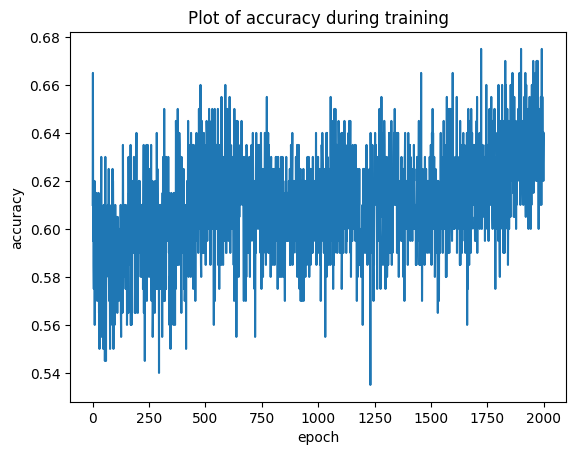

In [ ]:
plt.plot(acc)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Plot of accuracy during training")
plt.show()

Finally, evaluate the model on the test set.

In [ ]:
test_loss, test_acc = evaluate(
    model= lstm_model,
    features= x_test[:1000].to(device),
    labels = y_test[:1000].to(device),
    criterion=criterion
)
test_acc

tensor(0.4680, device='cuda:0')